# Practical Assignment 6

In this assignment a GAN is trained on the MNIST dataset. The MNIST dataset (provided by Yann Lecun) consists of handwritten digits of which an example is shown in figure 1. 

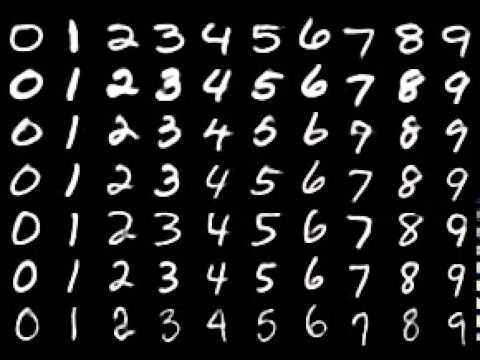

Figure 1: An example of the MNIST dataset

#### Imports

In [55]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from utils import RandomIterator, get_mnist # as provided in the course
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

### Exercise 1: implement generator and discriminator and plot  loss

####  Defining the generator
In the class below the structure of the generator  is defined and a classifier wrapper is defined. The generator has one fully connected layer with relu activation, followed by batchnormalization and deconvolution with a sigmoid activation function.  the gen function generates a noise vector of 100 components which the generator gets as input


In [83]:
class Generator(Chain):
    def __init__(self):
        super(Generator, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(100, 1)
            self.b1 = L.BatchNormalization(1)
            self.d1 = L.Deconvolution2D(1, 28, outsize=(28, 28))
            
    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.reshape(h,(1, 1, 1, 1))
        h = self.b1(h)
        output = F.sigmoid(self.d1(h))
        return output
    
    def gen(self): 
        return np.random.uniform(-1, 1, (1, 100, 1, 1)) \
    .astype(np.float32)

    
class Classifier_Gen(Chain):
    """
    
    Classifier chain on top of Neural Network chain 
    
    """
    def __init__(self, predictor):
        super(Classifier_Gen, self).__init__()
        with self.init_scope():
            self.predictor = predictor
    
    def __call__(self, x):
        y = self.predictor(x)
        return y

#### Defining the discriminator
In the class below the structure of the discriminator is defined and a classifier wrapper is defined. The discriminator has one convolutional laye with relu activation folowed by a fully connected layer with a sigmoid activation function.

In [84]:
class Discriminator(Chain):
    def __init__(self):
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=None, out_channels=5, ksize=5, stride=1, pad=0)
            self.l1 = L.Linear(None, 1)
        
    def __call__(self, x):

        h = F.relu(self.conv1(x))
        output = F.sigmoid(self.l1(h))
        return output
    
class Classifier_Dis(Chain):
    """
    
    Classifier chain on top of Neural Network chain 
    
    """
    def __init__(self, predictor):
        super(Classifier_Dis, self).__init__()
        with self.init_scope():
            self.predictor = predictor
    
    def __call__(self, x):
        y = self.predictor(x)
        return y

#### Training set creation

In [96]:
# Retrieve train & test data      
train_data, test_data = get_mnist(n_train=1000, n_test=100, with_label=False, classes=[0])

#### Define discriminator and generator
Here we define the two networks and their optimizers. We use Adam for both networks

In [89]:
dis = Discriminator()
classifier_dis = Classifier_Dis(dis)
optimizer_dis = optimizers.Adam()
optimizer_dis.setup(classifier_dis)

gen = Generator()
classifier_gen = Classifier_Gen(gen)
optimizer_gen = optimizers.Adam()
optimizer_gen.setup(classifier_gen)

In [90]:
ri = RandomIterator(train_data, 1)
gen_loss = []
dis_loss = []
for step, sample in enumerate(ri):
    x = sample[0][0].astype('float32')
    x = F.reshape(x,(1,1,28,28))
    z = gen.gen().astype('float32')
    x_fake = classifier_gen(z)
    
    # Update Discriminator
    classifier_dis.cleargrads()
    y_fake = F.sum(classifier_dis(x_fake)) 
    y_real = F.sum(classifier_dis(x))
    loss_d = -0.5*F.log(y_real) - 0.5*F.log(1 - y_fake)
    dis_loss.append({'step': step, 'loss': loss_d.data})
    loss_d.backward()
    optimizer_dis.update()

    # Update Generator
    gen.cleargrads()
    loss_g = -0.5*F.log(y_fake)
    gen_loss.append({'step': step, 'loss': loss_g.data})
    loss_g.backward()
    optimizer_gen.update()    

#### Plotting change in loss of generator and discriminator
Below you can see the plotted loss of the discriminator and generator plotted for 1000 steps.

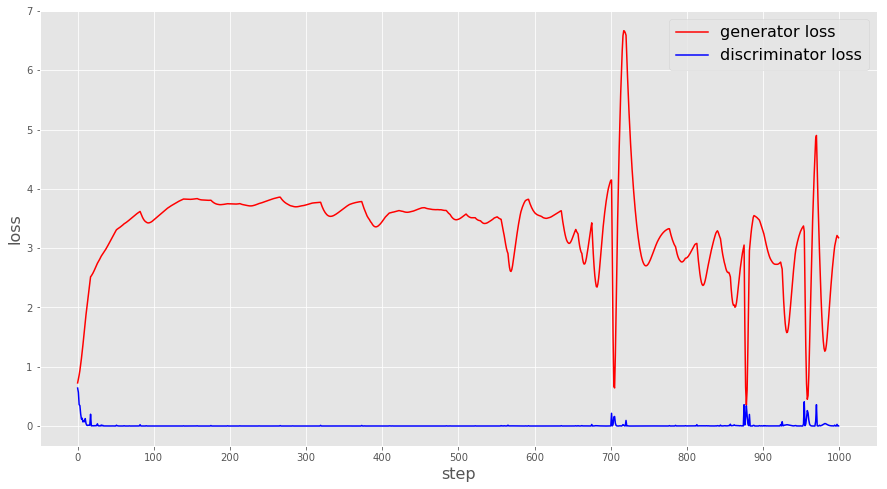

In [103]:
def visualize_loss(gen_loss, dis_loss, nr_steps=50):
    matplotlib.style.use('ggplot')
    figure = plt.figure(figsize=(15,8))
    ax = figure.add_subplot(111)
    ax.set_xlabel('step',fontsize=16)
    ax.set_ylabel('loss', fontsize=16)
    xticks = np.arange(0, nr_steps+1, 100)
    ax.set_xticks(xticks)  
    e_gen, l_gen = [point['step'] for point in gen_loss], [point['loss'] for point in gen_loss]
    e_dis, l_dis = [point['step'] for point in dis_loss], [point['loss'] for point in dis_loss]
    gen, = plt.plot(e_gen, l_gen, 'r', label = 'gen loss')
    dis, = plt.plot(e_dis, l_dis, 'b', label = 'dis loss')
    plt.legend([gen, dis], ['generator loss', 'discriminator loss'],fontsize=16)
    plt.show() 
visualize_loss(gen_loss, dis_loss, nr_steps=1000)

### Exercise 2: Generate 10 samples and comment on results
Below we generate 10 samples of zeros. From the results you can see that the quality of samples is rather good, but not perfect. The images look like zeros but there are some small distortions, that make them look a bit blurred. This is to be expected since the generator still has a rather high loss.

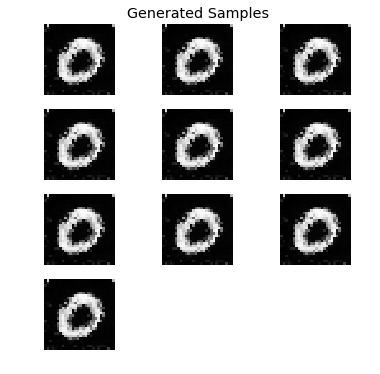

In [104]:
fig = plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('Generated Samples')
for i in range(10):
    z = gen.gen().astype('float32')
    fake = classifier_gen(z)
    fake = F.reshape(fake, (28,28)).data
    sub = fig.add_subplot(4,3,i+1)
    sub.imshow(fake, cmap = 'gray')
    plt.axis('off')